<a href="https://colab.research.google.com/github/isakernir1/kerfislif/blob/main/Copy_of_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load common Python modules

In [ ]:
!cat /proc/cpuinfo
import multiprocessing,multiprocessing.pool
threads = 2

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
import numpy
import matplotlib, matplotlib.pyplot
# some matplotlib parameters to make figures look nice
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'axes.labelsize':20})

# Install  and load modules related to cobra

In [ ]:
 !pip install rich==6.2.0
 !pip install cobra

     |████████████████████████████████| 153kB 7.9MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 2.4MB 8.6MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 6.2MB 20.9MB/s 
     |████████████████████████████████| 2.1MB 43.5MB/s 
     |████████████████████████████████| 133kB 35.6MB/s 
     |████████████████████████████████| 10.1MB 28.1MB/s 
     |████████████████████████████████| 71kB 2.3MB/s 
     |████████████████████████████████| 552kB 42.4MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 


In [ ]:
import cobra.test
from cobra import Model, Reaction, Metabolite
from cobra.util.solver import linear_reaction_coefficients

# Load model

In [ ]:
model = cobra.io.load_json_model('iIsor850.json')
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
btn_c,EX_btn_c,0.0001033,10,0.00%
ca2_e,EX_ca2_e,0.001329,0,0.00%
cu2_e,EX_cu2_e,0.0001178,0,0.00%
fe2_e,EX_fe2_e,0.0007893,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.6237,0,0.00%
mg2_e,EX_mg2_e,0.06571,0,0.00%
mn2_e,EX_mn2_e,9.712E-05,0,0.00%
nh4_e,EX_nh4_e,6.879,0,0.00%
o2_e,EX_o2_e,18.21,0,0.00%


# Double-KO analysis

In [ ]:
def get_pairs(rxns):

  """
  Returns a list of reaction pairs from rxns
  """

  working_pairs = []
  for i in range(len(rxns)):
    for j in range(len(rxns)):
      if i < j:
        pair = (str(rxns[i].id), str(rxns[j].id))
        working_pairs.append(pair)

  return working_pairs

In [ ]:
def genetic_interventioner(pair):

  '''
  This function returns a phenotype given a pair of genes to KO.
  '''
  
  model = cobra.io.load_json_model('iIsor850.json')

  model.reactions.get_by_id(pair[0]).lower_bound = 0
  model.reactions.get_by_id(pair[0]).upper_bound = 0
  model.reactions.get_by_id(pair[1]).lower_bound = 0
  model.reactions.get_by_id(pair[1]).upper_bound = 0

  sol = model.optimize()

  if sol.status != 'optimal':
    Vbio_max = 0
  else:
    Vbio_max = sol.objective_value

  model.objective = molecule_of_interest #set objective to target given chemical
  model.reactions.get_by_id('Biomass_Isor').lower_bound = Vbio_max
  maximum = model.optimize(objective_sense='maximize').objective_value
  minimum = model.optimize(objective_sense='minimize').objective_value

  phenotype = [pair, Vbio_max, minimum, maximum]

  return phenotype

In [ ]:
def filter_reactions(model):
  with model:
    reactions_to_remove = [] #Clean list
    for reaction in model.reactions: #Iterate over the reactions
      model2 = model.copy()
      id = reaction.id #Get the ID, e.g. 'EX_ac_e'
      subsystem = reaction.subsystem 
      if id[-1] == 't': #if last char is t, remove it 
        reactions_to_remove.append(id)
      elif id[0:3] == 'EX_': #if the first letters are EX_ (exhange), remove it 
        reactions_to_remove.append(id)
      elif subsystem == 'Transport': 
        reactions_to_remove.append(id)
      elif id[-3:] == 't2r':
        reactions_to_remove.append(id)
      else:
        model2.reactions.get_by_id(reaction.id).lower_bound = 0
        model2.reactions.get_by_id(reaction.id).upper_bound = 0
        sol_tmp = model2.optimize()
        if sol_tmp.objective_value < 1e-4:
          reactions_to_remove.append(id)
  model3 = model.copy()
  model3.remove_reactions(reactions_to_remove) #Remove those reactions
  rxns = model3.reactions #DictList of reactions after removal. 
  return rxns

In [ ]:
# identify molecule of interest
molecule_of_interest = 'EX_fum_e'

# Identify the reactions of interest:
rxns_to_test = filter_reactions(model)
print('selected {} reactions to work with'.format(len(rxns_to_test)))

/usr/local/lib/python3.7/dist-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


selected 815 reactions to work with


## find the best growth-coupled design

In [ ]:
#pairs = get_pairs(rxns_to_test[:10])
pairs = get_pairs(rxns_to_test)
#pairs500 = pairs[:500]
print('{} reactions implies {} testing pairs'.format(len(rxns_to_test), len(pairs)))

815 reactions implies 331705 testing pairs


Initial serial approach took 4min 38s
Current simplified serial approach takes xx
Parallel approach takes xx

In [ ]:
%%time
phenotypes = []
for pair in pairs:
  phenotype = genetic_interventioner(pair)
  phenotypes.append(phenotype)

CPU times: user 15min 12s, sys: 31.4 s, total: 15min 44s
Wall time: 15min 46s


The code above took 15-ish minutes for 500 reaction pairs

In [ ]:
best_pair = None; best_min = 0
for phenotype in phenotypes:
  if phenotype[2] > best_min:
    best_pair = phenotype; best_min = phenotype[2]
print(best_pair)

None


In [ ]:
%%time
hydra = multiprocessing.pool.Pool(threads)
phenotypes = hydra.map(genetic_interventioner, pairs)
hydra.close()

Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.7/multiprocessing

KeyboardInterrupt: ignored

In [ ]:
best_pair = None; best_min = 0
for phenotype in phenotypes:
  if phenotype[2] > best_min:
    best_pair = phenotype; best_min = phenotype[2]
print(best_pair)

None


## double-KO results analysis

Lets have a look at our best pair:

In [ ]:
# ['ATPS4r', 'SUCDi', 0.37422987493311083, 14.312267245829135, 14.31226724582913]
best_pair

[('ATPS4r', 'SUCDi'),
 0.37422987493311083,
 14.312267245829135,
 14.31226724582913]

Plot the WT (non-perturbed) production of biomass vs production of compound (black) and the reaction pair knockout (perturbed) production of biomass vs production of compound (red):

In [ ]:
model = cobra.io.load_json_model('iIsor850.json') # Need a clean version
baseline_growth = model.optimize().objective_value
wild_xs = [] ; wild_ys = []
bm_range = numpy.linspace(0, baseline_growth, 100)
model.objective = molecule_of_interest
for bm in bm_range:
  model.reactions.get_by_id('Biomass_Isor').lower_bound = bm
  model.reactions.get_by_id('Biomass_Isor').upper_bound = bm
  sol = model.optimize()
  if sol.status == 'optimal':
    wild_xs.append(bm)
    wild_ys.append(sol.objective_value)

In [ ]:
mins = []; maxs=[]
test_model = cobra.io.load_json_model('iIsor850.json') 
test_model.remove_reactions([best_pair[0][0], best_pair[0][1]])
sol_test = test_model.optimize().objective_value

sol_test_range = numpy.linspace(0, sol_test, 25)
test_model.objective = molecule_of_interest 
for bm in sol_test_range:
  test_model.reactions.get_by_id('Biomass_Isor').lower_bound = bm
  maxs.append(test_model.optimize(objective_sense='maximize').objective_value)
  mins.append(test_model.optimize(objective_sense='minimize').objective_value)

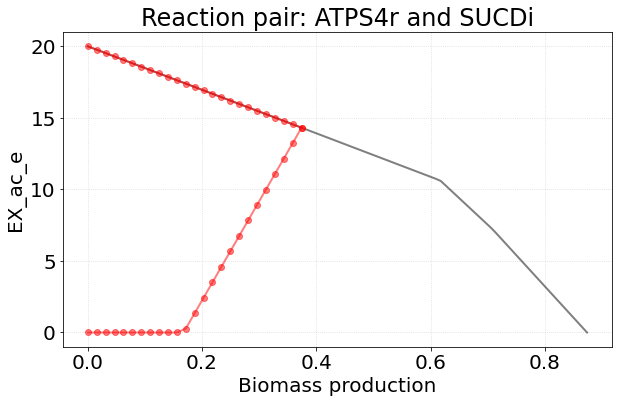

In [ ]:
matplotlib.pyplot.figure(figsize=(9, 6))

matplotlib.pyplot.plot(wild_xs, wild_ys, color='black', lw=2, alpha=0.5)
matplotlib.pyplot.plot(sol_test_range, mins, 'o-', color='red', lw=2, alpha=0.5)
matplotlib.pyplot.plot(sol_test_range, maxs, 'o-', color='red', lw=2, alpha=0.5)

matplotlib.pyplot.xlabel('Biomass Biomass_Isor')
matplotlib.pyplot.ylabel('EX_fum_e')
matplotlib.pyplot.title('Reaction pair: ' + best_pair[0][0]+ ' and ' + best_pair[0][1])

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()